In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.linalg import block_diag
import h5py
import os
import itertools
import pandas as pd
import gvar as gv
import lsqfit
from importlib import reload
from tqdm import tqdm
import datetime
from functools import reduce
from collections import namedtuple
import matplotlib.patches as mpatches

# Patrick imports
from utils import *
import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from fittools import *
from formattools import *
import plottools as pt

style = styles['talk']

pt.set_font()

# Will imports
import data_io_nn as io
sys.path.append('/Users/theoares/lqcd_analysis')
from lqcd_analysis import visualize as wplt
from lqcd_analysis import correlator
from lqcd_analysis import analysis
from lqcd_analysis import statistics as stats

In [2]:
out_dir = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks'
def to_mass(am):
    """Converts a mass in lattice units to physical units (MeV)."""
    a_fm = 0.145
    hbarc = 197
    return am * hbarc / a_fm

In [3]:
a_fm = 0.145
hbarc = 197
mpi = 806    # MeV
L = 32

In [6]:
3200 * a_fm / hbarc

2.355329949238578

In [5]:
mpi * a_fm / hbarc * 32

18.983959390862942

In [3]:
def count_ndata(ydata):
    """ Counts the number of data points in ydata."""
    ndata = 0
    if hasattr(ydata, 'keys'):
        for key in ydata.keys():
            ndata += len(np.asarray(ydata[key]).flatten())
    else:
        ndata = len(np.asarray(ydata).flatten())
    return ndata


def count_nparams(params):
    """
    Counts the number of fit parameters np, being careful
    to avoid double counting of "log priors" are present.
    """
    nparams = 0
    for pname, val in params.items():
        log_pname = 'log({0})'.format(pname)
        if log_pname in params.keys():
            # Skip this parameter
            continue
        if hasattr(val, '__len__'):
            nparams += len(np.asarray(val).flatten())
        else:
            nparams += 1
    return nparams


def aic(fit):
    """
    Computes the Akaike information criterion for a given fit.
    """
    return fit.chi2 + 2.0 * count_nparams(fit.p)


def aic_model_probability(fit):
    """
    Computes the model probability associated with the Akaike information
    criterion. Generically, the raw (unnormalized) model probability is
    raw prob = exp( -0.5 * IC).
    In the present case,
    IC = AIC - 2*(Ny - Ncut)
       = chi^2 + 2*Nparams - 2*(Ny - Ncut).
    This definition uses the following pieces:
    * chi^2 is the augmented chi2,
    * Nparams is the number of parameters in the model,
    * Ny is the total number data points, and
    * Ncut is the number of points cut / dropped by choosing tmin
    The difference (Ny - Ngamma) > 0 is simply "Ndata", the total number of
    data points included in the fit. For a fixed model and fixed raw dataset,
    Nparams and Ny are constant and cancel in the normalized probabilites used
    in model averaging. So, for fixed model and fixed raw dataset,
    IC --> chi^2 + 2 Ncut.
    """
    ndata = count_ndata(fit.y)
    ic = aic(fit) - 2.0 * ndata
    # Recall the basic log-likelihood function in least-squares fitting is
    # -1/2 * chi2^2, with a factor of -1/2. So we must multiply the information
    # criterion by -1/2 in order to get the full log-likelihood.
    log_likelihood = -0.5 * ic
    return np.exp(log_likelihood)

from inspect import getfullargspec

def compute_chi2(fit, augmented=False, trust_lsqfit=False):
    """Computes the chi2 function."""
    if trust_lsqfit:
        if not augmented:
            LOGGER.warning((
                "Caution: lsqfit computes an augmented chi2 function."
                "Trusting lsqfit as specified anyway."
            ))
        return fit.chi2
    # Standard chi2, without the term involving the prior
    argspec = getfullargspec(fit.fcn)
    if (argspec.args == ['x', 'p']) or (argspec.args == ['self', 'x', 'p']):
        result = correlated_chi2(fit.fcn(fit.x, fit.p), fit.y)
    else:
        result = correlated_chi2(fit.fcn(fit.p), fit.y)
    if augmented:
        # Augmeted chi2, including the term with the prior
        result += correlated_chi2(fit.p, fit.prior)
    return result

def correlated_chi2(yfit, ydata):
    """Computes the correlated chi2 function."""
    # Get the fit values, data, and covariance matrix as dicts
    cov_dict = gv.evalcov(ydata)
    # Enforce an ordering of keys
    klist = list(ydata.keys())
    # Reserve space for arrays
    # Implementation note: flatten allows for the special case
    # of matrix-valued priors, e.g., for the transition matrix Vnn
    sizes = [len(np.asarray(ydata[key]).flatten()) for key in klist]
    total_size = sum(sizes)
    diff = np.empty(total_size)
    cov_arr = np.zeros((total_size, total_size))
    # Infer the start and end points for intervals
    ends = np.cumsum(sizes)
    starts = ends - sizes
    # Populate arrays
    for start_i, end_i, key_i in zip(starts, ends, klist):
        diff[start_i:end_i] = np.asarray(gv.mean(ydata[key_i] - yfit[key_i])).flatten()
        for start_j, end_j, key_j in zip(starts, ends, klist):
            try:
                cov_arr[start_i:end_i, start_j:end_j] =\
                    cov_dict[(key_i, key_j)]
            except ValueError:
                # Implementation note: matrix-valued priors have
                # multi-dimensional covariance matrices,
                # which must be reshaped in a 2x2 array
                cov_arr[start_i:end_i, start_j:end_j] = \
                    cov_dict[(key_i, key_j)].reshape(
                        end_i - start_i, end_j - start_j
                    )
    # The "usual" chi2 function (ydata-yfit).cov_inv.(ydata-yfit)
    try:
        result = np.dot(diff, np.linalg.solve(cov_arr, diff))
    except np.linalg.LinAlgError:
        result = np.nan
    return result

## Read and process data

In [4]:
reload(io)

# runs = ['A', 'B', 'C', 'D', 'E', 'F']
runs = ['C', 'D', 'E', 'F']
# root = "/Users/willjay/Research/BetaDecay/Data/NN/production-runs-{run}-no-sparsening/results/all/"
root = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/raw/run_{run}/'

tags = [
    "dinucleon-2pt-PP",
#     "dinucleon-2pt-PP-full",
    "dinucleon-2pt-WP",
#     "nnpp-3pt",
#     "nnpp-4pt",
    "nucleon-2pt-WP",
#     "sigma-3pt",
#     "sigma-4pt",
]
corrs = {}
data = {}
tcut = 24
for tag in tags:
    print(f"Reading {tag}")
    data_tmp = []  # accumulate data across runs
    for run in runs:
        fname = os.path.join(root.format(run=run), tag)
        try:
            raw = io.read_2pt(fname)
        except FileNotFoundError:
            print(f"--> Missing {tag} {run}")
            continue
        arr = io.avg_src_2pt(raw)
        arr = arr[:, :tcut]
        if tag == "nucleon-2pt-WP":
            arr = -1*arr
        print(f"--> {run} {arr.shape}")
        data_tmp.append(arr)
    data[tag] = np.vstack(data_tmp)
ds = gv.dataset.avg_data(data)
    
# Normalize
for key in ds:
    ds[key] = ds[key] / gv.mean(ds[key][0])
    
    
    # data = gv.dataset.avg_data(data)

# c2 = correlator.TwoPoint(tag, gv.dataset.avg_data(data))
# corrs[tag] = c2


Reading dinucleon-2pt-PP
--> C (1057, 24)
--> D (3524, 24)
--> E (2871, 24)
--> F (3040, 24)
Reading dinucleon-2pt-WP
--> C (1057, 24)
--> D (3524, 24)
--> E (2871, 24)
--> F (3040, 24)
Reading nucleon-2pt-WP
--> C (1057, 24)
--> D (3524, 24)
--> E (2871, 24)
--> F (3040, 24)


dinucleon-2pt-PP
dinucleon-2pt-WP
nucleon-2pt-WP


(2.0, 3.0)

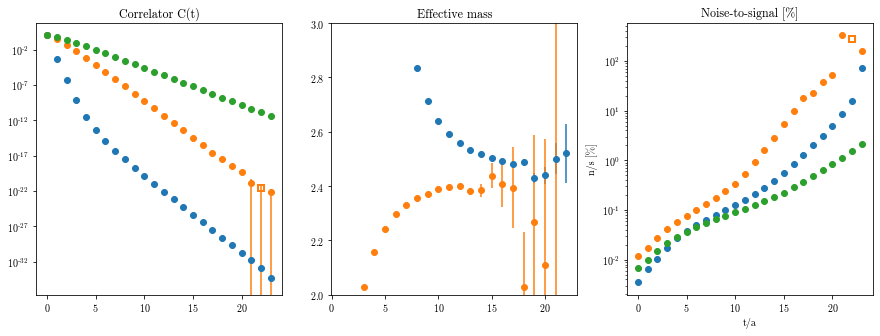

In [5]:
fig, axarr = wplt.subplots(ncols=3, figsize=(15, 5))
for k, v in ds.items():
    # fig, axarr = wplt.subplots(ncols=3, figsize=(15, 5))
    print(k)
    c2 = correlator.TwoPoint(k, v)
    c2.plot_summary(axarr=axarr)
axarr[1].set_ylim(2, 3)

In [6]:
def model_pp(t, p):
    amp_wall = p['amp:w']
    amp_point = p['amp:p']
    dE = p['dE']
    result = 0
    for E, ai in zip(np.cumsum(dE), amp_point):
        result = result + (ai**2) * np.exp(-E*t)
    return result

def model_wp(t, p):
    amp_wall = p['amp:w']
    amp_point = p['amp:p']
    dE = p['dE']
    result = 0
    for E, ai, bi in zip(np.cumsum(dE), amp_wall, amp_point):
        result = result + (ai*bi) * np.exp(-E*t)
    return result

class Fitter:
    def __init__(self, y, diag=True):
        self.y = y
        self.diag = diag
        
    def get_prior(self, nstates):
        mpi_MeV = 800
        a_fm = 0.145
        hbarc = 197
        mpi = mpi_MeV * a_fm / hbarc
        if self.diag:
            dE = [gv.gvar(2.5, 0.1)] + [gv.gvar(mpi, mpi) for _ in range(nstates-1)]
        else:
            dE = [gv.gvar(2.5, 0.5)] + [gv.gvar(mpi, mpi) for _ in range(nstates-1)]
        amp = [gv.gvar(0, 5.)] + [gv.gvar(0.5, 5) for _ in range(nstates-1)]
        return {'dE': dE, 'amp': amp}

    def model(self, t, p):
        amp = p['amp']
        dE = p['dE']
        result = 0
        for E, ai in zip(np.cumsum(dE), amp):
            if self.diag:
                # Convexity of diagonal correlators
                result = result + ai*np.sign(ai) * np.exp(-E*t)
            else:
                result = result + ai * np.exp(-E*t)
        return result
    
    def __call__(self, nstates, tmin, tmax=None, **kwargs):
        prior = kwargs.pop('prior', self.get_prior(nstates))    
        if tmax is None:
            tmax = len(self.y)
        x = np.arange(tmin, tmax)
        y = self.y[tmin:tmax]
        return lsqfit.nonlinear_fit(data=(x, y), fcn=self.model, prior=prior, **kwargs)

## Nucleon fits

In [7]:
#################
# Wall-to-point #
#################

key = 'nucleon-2pt-WP'
fitter = Fitter(y=ds[key], diag=False)
fits_N = []
for nstates in range(1, 6):
    for tmin in range(4, 12):
        fit = fitter(nstates=nstates, tmin=tmin)
        result = {
            'key': key,
            'nstates': nstates,
            'tmin': tmin,
            'chi2/dof': fit.chi2/fit.dof,
            'Q': fit.Q,
            'fit': fit,
        }
        for idx, E in enumerate(np.cumsum(fit.p['dE'])):
            result[f'E:{idx}'] = E
        for idx, amp in enumerate(fit.p['amp']):
            result[f'amp:{idx}'] = amp
        fits_N.append(result)

# fits_N is a pandas DataFrame of all the fits, indexed by results
fits_N = pd.DataFrame(fits_N)        

,nstates,tmin,E:0,chi2/dof,Q
7,1,11,1.20239(36),1.623908,0.070766
14,2,10,1.2044(10),1.328635,0.180767
16,3,4,1.1994(52),1.807563,0.014763
17,3,5,1.192(22),1.465016,0.086650
19,3,7,1.20421(58),1.466101,0.096430
22,3,10,1.2044(10),1.328889,0.180621
23,3,11,1.2039(12),1.338675,0.181539
24,4,4,1.193(20),1.535020,0.059272
25,4,5,1.191(26),1.400493,0.114086
28,4,8,1.20390(63),1.486172,0.094449


<AxesSubplot:>

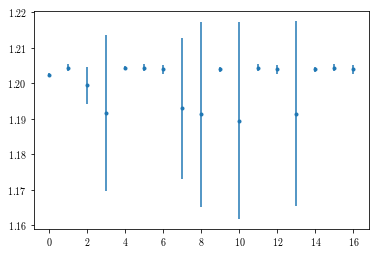

In [8]:
# Only look at fits with chi^2 / dof < 2 and noise-to-signal ratio < 0.1 (less than 10% noise)
mask =\
    (fits_N['chi2/dof'] <= 2) &\
    (fits_N['E:0'].apply(analysis.n2s) < 0.1)

display(fits_N[mask][['nstates','tmin','E:0','chi2/dof','Q']])

fig, ax = plt.subplots(1)

y = fits_N[mask]['E:0']


x = np.arange(len(y))
wplt.errorbar(ax, x, y, fmt='.')

## Individual dinucleon fits (WP and PP)

In [59]:
fits = []

##################
# Point-to-point #
##################

key = 'dinucleon-2pt-PP'
fitter = Fitter(y=ds[key], diag=True)
for nstates in range(1, 6):
    for tmin in range(4, 12):
        fit = fitter(nstates=nstates, tmin=tmin)
        result = {
            'key': key,
            'nstates': nstates,
            'tmin': tmin,
            'chi2/dof': fit.chi2/fit.dof,
            'Q': fit.Q,
            'fit': fit,
            'weight' : aic_model_probability(fit),
        }
        for idx, E in enumerate(np.cumsum(fit.p['dE'])):
            result[f'E:{idx}'] = E
        for idx, amp in enumerate(fit.p['amp']):
            result[f'amp:{idx}'] = amp
        fits.append(result)

#################
# Wall-to-point #
#################

key = 'dinucleon-2pt-WP'
fitter = Fitter(y=ds[key], diag=False)
for nstates in range(1, 6):
    for tmin in range(4, 12):
        fit = fitter(nstates=nstates, tmin=tmin)
        #fit = fitter(nstates=nstates, tmin=tmin, tmax = 20)
        result = {
            'key': key,
            'nstates': nstates,
            'tmin': tmin,
            'chi2/dof': fit.chi2/fit.dof,
            'Q': fit.Q,
            'fit': fit,
            'weight' : aic_model_probability(fit)
        }
        for idx, E in enumerate(np.cumsum(fit.p['dE'])):
            result[f'E:{idx}'] = E
        for idx, amp in enumerate(fit.p['amp']):
            result[f'amp:{idx}'] = amp
        fits.append(result)

fits = pd.DataFrame(fits)

In [60]:
# snr_WP = gv.sdev(ds['dinucleon-2pt-WP']) / gv.mean(ds['dinucleon-2pt-WP'])

In [61]:
fits[fits['key'] == 'dinucleon-2pt-WP']

,key,nstates,tmin,chi2/dof,Q,fit,weight,E:0,amp:0,E:1,amp:1,E:2,amp:2,E:3,amp:3,E:4,amp:4
40,dinucleon-2pt-WP,1,4,2252.623125,0.000000e+00,Least Square Fit:\n chi2/dof [dof] = 2.3e+03 ...,0.000000e+00,2.28854(28),5.8938(61),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,dinucleon-2pt-WP,1,5,469.182731,0.000000e+00,Least Square Fit:\n chi2/dof [dof] = 4.7e+02 ...,0.000000e+00,2.32184(36),7.446(13),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,dinucleon-2pt-WP,1,6,93.759755,0.000000e+00,Least Square Fit:\n chi2/dof [dof] = 94 [18] ...,0.000000e+00,2.34685(50),8.951(26),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,dinucleon-2pt-WP,1,7,17.767985,4.237680e-54,Least Square Fit:\n chi2/dof [dof] = 18 [17] ...,8.391627e-60,2.36554(73),10.386(52),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,dinucleon-2pt-WP,1,8,5.577474,3.453215e-12,Least Square Fit:\n chi2/dof [dof] = 5.6 [16]...,5.034928e-14,2.3780(12),11.58(11),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,dinucleon-2pt-WP,1,9,1.174834,2.830310e-01,Least Square Fit:\n chi2/dof [dof] = 1.2 [15]...,6.594003e+01,2.3907(19),13.09(23),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,dinucleon-2pt-WP,1,10,1.090499,3.601511e-01,Least Square Fit:\n chi2/dof [dof] = 1.1 [14]...,7.876816e+01,2.3949(34),13.68(46),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,dinucleon-2pt-WP,1,11,1.164258,2.989796e-01,Least Square Fit:\n chi2/dof [dof] = 1.2 [13]...,3.094853e+01,2.3932(59),13.41(88),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,dinucleon-2pt-WP,2,4,2252.634167,0.000000e+00,Least Square Fit:\n chi2/dof [dof] = 2.3e+03 ...,0.000000e+00,2.29(23),3.3(3.5),2.29(29),2.6(3.5),NaN,NaN,NaN,NaN,NaN,NaN
49,dinucleon-2pt-WP,2,5,469.171229,0.000000e+00,Least Square Fit:\n chi2/dof [dof] = 4.7e+02 ...,0.000000e+00,2.32(23),4.1(3.5),2.32(29),3.3(3.5),NaN,NaN,NaN,NaN,NaN,NaN


## Plot WP fits

In [62]:
# Just WP fits
# mask = (fits['chi2/dof'] <= 2) & (fits['key'] == 'dinucleon-2pt-WP') 
mask = (fits['chi2/dof'] <= 2) & (fits['key'] == 'dinucleon-2pt-WP') & (fits['nstates'] == 1)
fits_WP = fits[mask]
fits_WP['weight'] = fits_WP['weight'] / np.sum(fits_WP['weight'])

fits_WP = fits_WP[fits_WP['weight'] >= 0.05]
ameff = stats.model_avg(fits_WP['E:0'].values, fits_WP['weight'].values)

# fits_WP[fits_WP.index == fits_WP['weight'].idxmax()]
# best_fit = fits_WP[fits_WP.index == fits_WP['weight'].idxmax()]
# ameff = best_fit['E:0'].values[0]

# print(f'Weighted average of effective mass: {ameff}.')
print(f'Effective mass ~ {ameff}.')

Effective mass ~ 2.3930(40).


/var/folders/q2/tk_jvj_106gddw96ph0kg7r40000gn/T/ipykernel_97067/3558043580.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fits_WP['weight'] = fits_WP['weight'] / np.sum(fits_WP['weight'])


In [63]:
fits_WP

,key,nstates,tmin,chi2/dof,Q,fit,weight,E:0,amp:0,E:1,amp:1,E:2,amp:2,E:3,amp:3,E:4,amp:4
45,dinucleon-2pt-WP,1,9,1.174834,0.283031,Least Square Fit:\n chi2/dof [dof] = 1.2 [15]...,0.375391,2.3907(19),13.09(23),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,dinucleon-2pt-WP,1,10,1.090499,0.360151,Least Square Fit:\n chi2/dof [dof] = 1.1 [14]...,0.448421,2.3949(34),13.68(46),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,dinucleon-2pt-WP,1,11,1.164258,0.298980,Least Square Fit:\n chi2/dof [dof] = 1.2 [13]...,0.176188,2.3932(59),13.41(88),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
style = styles['talk_onecol']
# style['colwidth'] = 1000.0 / pts_per_inch
# style['asp_ratio'] = 16 / 9
# style['colwidth'] = 900.0 / pts_per_inch
# style['asp_ratio'] = 4/3
# style['fontsize'] = 50.0
# # style['markersize'] = 10.0
# style['tick_fontsize'] = 30.0
# style['leg_fontsize'] = 25.0

# style['markersize'] = 20
# style['ebar_width'] = 3.0
# style['endcaps'] = 5.0

style0 = copy(style)

leg_loc = (1., 1.)
colors = sns.color_palette(n_colors = 4)

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/twoptWP_fit.pdf.


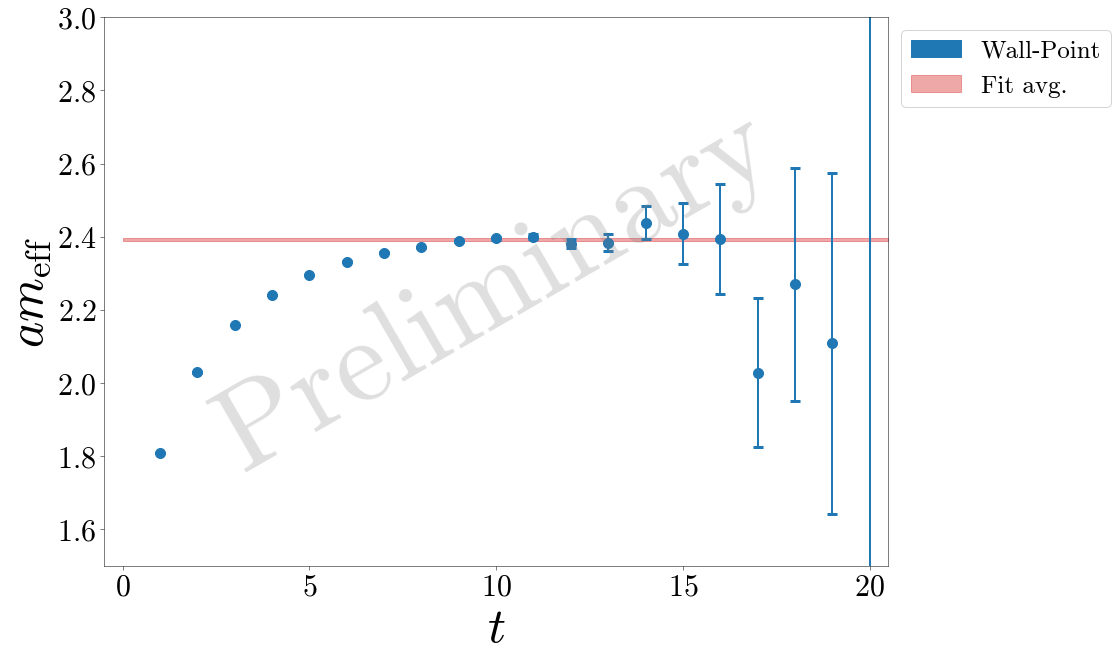

In [65]:
reload(pt)

fig, axes = pt.add_subplots(style = style0)
ax0 = axes[0]

idx = 0
patches = []
key = 'dinucleon-2pt-WP'
y = correlator.effective_mass(ds[key])
patches.append( 
   mpatches.Patch(color = colors[0], label = 'Wall-Point')
)
cvs = gv.mean(y)
stds = gv.sdev(y)
x = np.arange(len(y))
pt.errorbar_1d(x, cvs, stds, ax = ax0, col = colors[idx], style = style0)
    #wplt.errorbar(ax, x, y, fmt='.', capsize=5, label=key)

x = np.arange(0, 24)
# x = np.arange(10, 24)
y = np.ones(len(x)) * ameff
# pt.errorbar_1d(x, gv.mean(y), gv.sdev(y), ax = ax0, col = colors[-1])
ax0.fill_between(x, gv.mean(y) - gv.sdev(y), gv.mean(y) + gv.sdev(y), color = colors[-1], alpha = 0.4)
# patches.append(mpatches.Patch(color = colors[-1], label = r'$am_{pp}$', alpha = 0.5))
patches.append(mpatches.Patch(color = colors[-1], label = r'Fit avg.', alpha = 0.4))

pt.add_watermark(ax0, walpha = 0.25, wfontsize = 120)

ax0.set_xlim((-0.5, 20.5))
ax0.set_ylim((1.5, 3))

ax0.set_xlabel(r'$t$')
ax0.set_ylabel(r'$am_\mathrm{eff}$')
pt.stylize_axis(ax0, style = style0)

leg_loc = (1., 1.)
plt.legend(handles = patches, fontsize = style0['leg_fontsize'], bbox_to_anchor = leg_loc)

path = f'{out_dir}/twoptWP_fit.pdf'
pt.save_figure(path)
print(f'Output saved to {path}.')

## Back to more fitting

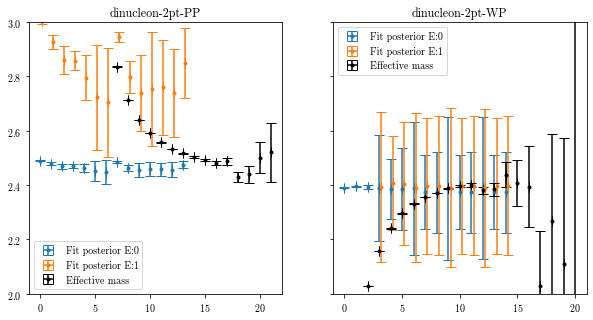

In [14]:
fig, axarr = wplt.subplots(ncols=2, sharey=True, figsize=(10, 5))

mask = fits['chi2/dof'] <= 2

# subdf is all accepted fits (i.e. all fits with chi^2/dof < 2), grouped by the 2 tags of WP and PP. 
# this first loop basically just loops over the two keys, either WP (wall-point) or PP (point-point)
for ax, (key, subdf) in zip(axarr, fits[mask].groupby('key')):
    # this loop goes over excited states, idx = 0 is ground state, idx = 1 is 1st excited state. 
    for idx in range(0, 2):
        y = subdf[f'E:{idx}']
        x = np.arange(len(y)) + idx*0.2
        wplt.errorbar(ax, x, y, fmt='.', capsize=5, label=f'Fit posterior E:{idx}')
    fit = subdf.head(1)['fit'].item()

    y = correlator.effective_mass(ds[key])
    x = np.arange(len(y))
    wplt.errorbar(ax, x, y, color='k', fmt='.', capsize=5, label='Effective mass')
    ax.set_ylim(2, 3)
    ax.legend()
    ax.set_title(key)

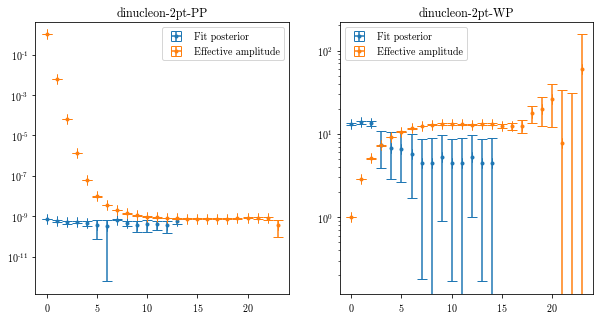

In [15]:
fig, axarr = wplt.subplots(ncols=2, figsize=(10, 5))

mask = (fits['chi2/dof'] <= 2)
for ax, (key, subdf) in zip(axarr, fits[mask].groupby('key')):
    
    # Plot fit posterior
    y = subdf['amp:0']
    x = np.arange(len(y))
    wplt.errorbar(ax, x, y, fmt='.', capsize=5, label='Fit posterior')
    
    # Plot effective amplitude
    E = subdf.head(1)['E:0'].item()
    y = ds[key] 
    t = np.arange(len(y))
    y = np.exp(+E*t) * y
    wplt.errorbar(ax, t, y, fmt='.', capsize=5, label='Effective amplitude')
    ax.set_yscale("log")
    ax.set_title(key)
    ax.legend()

## Joint dinucleon fits (WP and PP)

In [16]:
class JointFitter:
    def __init__(self, pp, wp):
        if len(pp) != len(wp):
            raise ValueError("Incommensurate data?")
        self.pp = pp
        self.wp = wp
    
    def model(self, x, p):
        return {'PP': model_pp(x, p), 'WP': model_wp(x, p)}
    
    def get_prior(self, nstates):
        mpi_MeV = 800
        a_fm = 0.145
        hbarc = 197
        mpi = mpi_MeV * a_fm / hbarc
    
        dE = [gv.gvar(2.5, 0.5)] + [gv.gvar(mpi, mpi) for _ in range(nstates-1)]
        amp_point = [gv.gvar(1.0, 0.25)] + [gv.gvar(0.5, 5) for _ in range(nstates-1)]
        amp_wall = [gv.gvar(0.5, 5) for _ in range(nstates)]
        return {'dE': dE, 'amp:p': amp_point, 'amp:w': amp_wall}
        
    def __call__(self, nstates, tmin, tmax=None, **kwargs):
        if 'prior' in kwargs:
            prior = kwargs.pop('prior')
        else:
            raise NotImplementedError("Please specify a prior")
        y = {'PP': self.pp[tmin:tmax], 'WP': self.wp[tmin:tmax]}
        if tmax is None:
            tmax = len(self.pp)
        x = np.arange(tmin, tmax)
        return lsqfit.nonlinear_fit(data=(x, y), fcn=self.model, prior=prior, **kwargs)

In [17]:
State = namedtuple('State', ['E','amp'])
NStates = namedtuple('Nstates', ['pp', 'wp'])

def build_prior(nstates, pp, wp):
    
    def bundle(mean, frac):
        return gv.gvar(mean, frac*mean)
    
    # Hard-coded ensemble-specific data
    mpi_MeV = 800
    a_fm = 0.145
    hbarc = 197
    mpi = mpi_MeV * a_fm / hbarc

    E0 = np.mean(gv.mean(pp.E) + gv.mean(wp.E))/2
    E0 = bundle(E0, 0.1)
    
    amp_p = np.sqrt(gv.mean(pp.amp))
    amp_w = gv.mean(wp.amp / amp_p)

    amp_p = bundle(amp_p, 2.5)
    amp_w = bundle(amp_w, 10)
        
    dE = [E0] + [gv.gvar(mpi, mpi) for _ in range(max(nstates)-1)]
    amp_point = [amp_p] + [gv.gvar(0.5, 5) for _ in range(nstates.pp-1)]
    amp_wall = [amp_w] +  [bundle(amp_w.mean, 5) for _ in range(nstates.wp-1)]    
    return {
        'log(dE)': np.log(dE),
        'log(amp:p)': np.log(amp_point),
        'amp:w': amp_wall}


# Isolate best fits
mask_pp = (fits['key'] == 'dinucleon-2pt-PP') & (fits['chi2/dof'] <= 2.0)
mask_wp = (fits['key'] == 'dinucleon-2pt-WP') & (fits['chi2/dof'] <= 2.0)

best_pp = (fits.index == fits[mask_pp]['chi2/dof'].idxmin())
pp = State(E=fits[best_pp]['E:0'].item(), amp=fits[best_pp]['amp:0'].item())

best_wp = (fits.index == fits[mask_wp]['chi2/dof'].idxmin())
wp = State(E=fits[best_wp]['E:0'].item(), amp=fits[best_wp]['amp:0'].item())

In [18]:
fitter = JointFitter(
    pp=ds['dinucleon-2pt-PP'], 
    wp=ds['dinucleon-2pt-WP'])

fits_joint = []

for tmin in range(3, 15):
    nstates = NStates(3, 2)
    prior = build_prior(nstates, pp, wp)
    fit = fitter(nstates=nstates, tmin=tmin, prior=prior)

    result = {
        'key': key,
        'nstates': nstates,
        'tmin': tmin,
        'chi2/dof': fit.chi2/fit.dof,
        'Q': fit.Q,
        'fit': fit,
    }
    for idx, E in enumerate(np.cumsum(fit.p['dE'])):
        result[f'E:{idx}'] = E
    for idx, amp in enumerate(fit.p['amp:w']):
        result[f'amp:w:{idx}'] = amp
    for idx, amp in enumerate(fit.p['amp:p']):
        result[f'amp:p:{idx}'] = amp
    fits_joint.append(result)
fits_joint = pd.DataFrame(fits_joint)
    

/var/folders/q2/tk_jvj_106gddw96ph0kg7r40000gn/T/ipykernel_97067/4107043006.py:3: RuntimeWarning: overflow encountered in exp
  amp_point = p['amp:p']


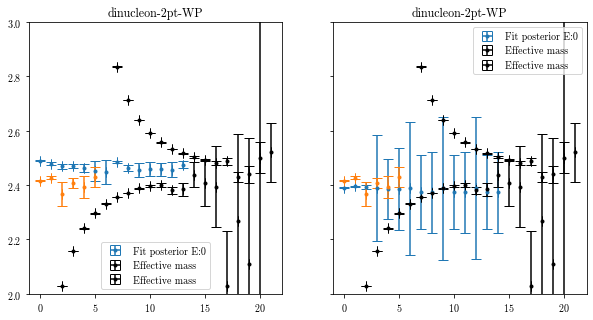

In [19]:
fig, axarr = wplt.subplots(ncols=2, sharey=True, figsize=(10, 5))

mask = fits['chi2/dof'] <= 2

for ax, (key, subdf) in zip(axarr, fits[mask].groupby('key')):

    # Single-fit results
    for idx in [0]:
        y = subdf[f'E:{idx}']
        x = np.arange(len(y)) + idx*0.2
        wplt.errorbar(ax, x, y, fmt='.', capsize=5, label=f'Fit posterior E:{idx}')
    fit = subdf.head(1)['fit'].item()

    # Joint-fit results
    mask = (fits_joint['chi2/dof'] <= 2.0)
    y = fits_joint[mask]['E:0']
    x = np.arange(len(y))
    wplt.errorbar(ax, x, y, fmt='.', capsize=5)

    # Effective masses
    for key in fits['key'].unique():
        y = correlator.effective_mass(ds[key])
        x = np.arange(len(y))
        wplt.errorbar(ax, x, y, color='k', fmt='.', capsize=5, label='Effective mass')
    
    ax.set_ylim(2, 3)
    ax.legend()
    ax.set_title(key)

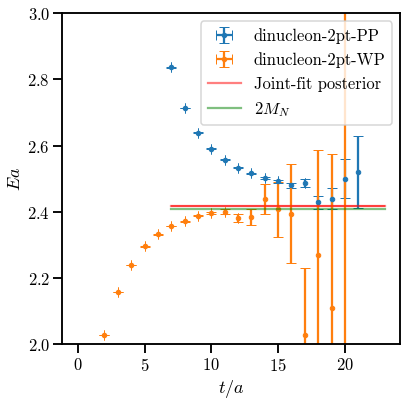

In [20]:
with sns.plotting_context("talk"):

    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(6, 6))
    for key in fits['key'].unique():
        y = correlator.effective_mass(ds[key])
        x = np.arange(len(y))
        wplt.errorbar(ax, x, y, fmt='.', capsize=5, label=key)

    mask = fits_joint['tmin'] == 7
    E = fits_joint[mask]['E:0'].item()
    x = np.arange(7, 24)
    y = np.ones(len(x))*E
    wplt.errorbar(ax=ax, x=x, y=y, color='r', bands=True, alpha=0.5, label='Joint-fit posterior')

    mask = (fits_N['tmin'] == 7) & (fits_N['nstates'] == 3)
    E = fits_N[mask]['E:0'].item()
    x = np.arange(7, 24)
    y = np.ones(len(x))*E*2
    wplt.errorbar(ax=ax, x=x, y=y, color='g', bands=True, alpha=0.5, label=r'$2 M_N$')

    ax.set_ylim(2, 3)
    ax.legend(loc='upper right')
    ax.set_xlabel(r"$t/a$")
    ax.set_ylabel(r"$Ea$")
    fig.tight_layout()
    #fig.savefig("Figures/dinucleon_fit.pdf")

In [21]:
fits_N[mask]

,key,nstates,tmin,chi2/dof,Q,fit,E:0,amp:0,E:1,amp:1,E:2,amp:2,E:3,amp:3,E:4,amp:4
19,nucleon-2pt-WP,3,7,1.466101,0.09643,Least Square Fit:\n chi2/dof [dof] = 1.5 [17]...,1.20421(58),4.266(33),1.683(33),-5.63(92),2.28(58),0.6(5.0),NaN,NaN,NaN,NaN


## Plot

In [22]:
style

{'colwidth': 12.453300124533001,
 'textwidth': 12.453300124533001,
 'fontsize': 50.0,
 'tickwidth': 0.5,
 'ticklength': 4.0,
 'spinewidth': 0.5,
 'axeswidth': 0.5,
 'markersize': 20.0,
 'ebar_width': 2.0,
 'endcaps': 5.0,
 'ecap_width': 3.0,
 'bottom_pad': 0.5,
 'top_pad': 1.5,
 'left_pad': 0.5,
 'right_pad': 1.5,
 'asp_ratio': 1.3333333333333333,
 'linewidth': 1.5,
 'tick_fontsize': 30.0,
 'leg_fontsize': 25.0,
 'wfontsize': 150}

In [23]:
style = styles['talk']
# style['colwidth'] = 1000.0 / pts_per_inch
# style['asp_ratio'] = 16 / 9
style['colwidth'] = 900.0 / pts_per_inch
style['asp_ratio'] = 4/3
style['fontsize'] = 50.0
# style['markersize'] = 10.0
style['tick_fontsize'] = 30.0
style['leg_fontsize'] = 25.0

style['markersize'] = 20
style['ebar_width'] = 3.0
style['endcaps'] = 5.0

style0 = copy(style)

leg_loc = (1., 1.)
colors = sns.color_palette(n_colors = 4)
colors = [colors[0], colors[2], colors[3]]

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/twopt_fit.pdf.


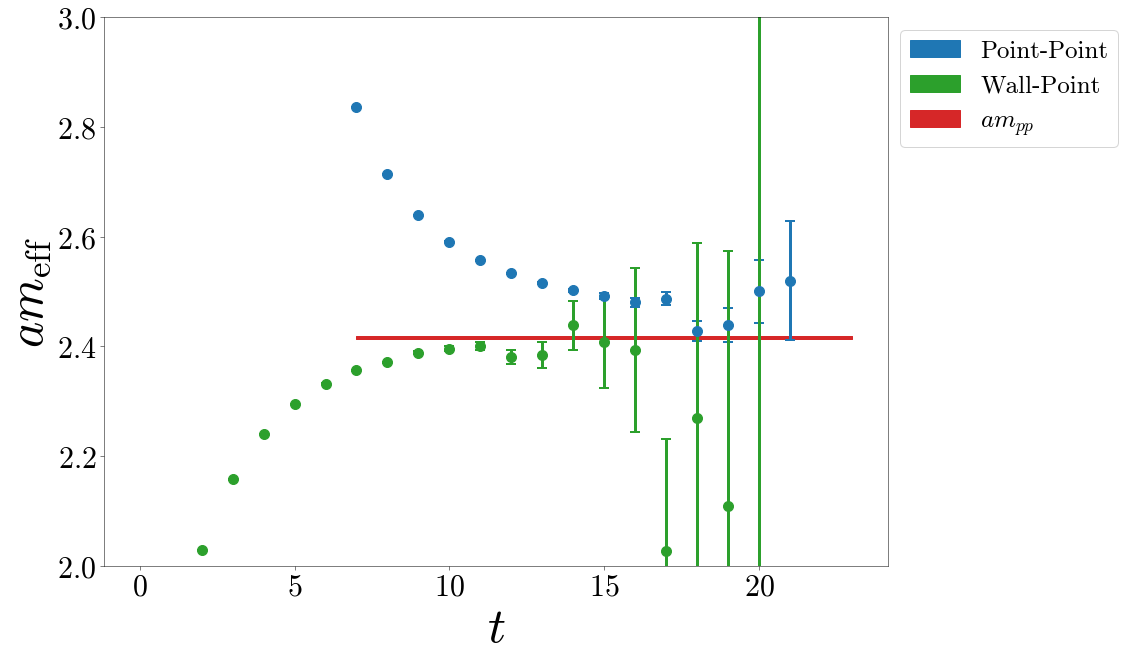

In [24]:
fig, axes = pt.add_subplots(style = style0)
ax0 = axes[0]

idx = 0
patches = []
labels = ['Point-Point', 'Wall-Point']
for key in fits['key'].unique():
    y = correlator.effective_mass(ds[key])
    patches.append( 
       mpatches.Patch(color = colors[idx], label = labels[idx])
    )
    cvs = gv.mean(y)
    stds = gv.sdev(y)
    x = np.arange(len(y))
    pt.errorbar_1d(x, cvs, stds, ax = ax0, col = colors[idx], style = style0)
    idx += 1
    #wplt.errorbar(ax, x, y, fmt='.', capsize=5, label=key)

mask = fits_joint['tmin'] == 7
E = fits_joint[mask]['E:0'].item()
x = np.arange(7, 24)
y = np.ones(len(x))*E
# pt.errorbar_1d(x, gv.mean(y), gv.sdev(y), ax = ax0, col = colors[-1])
ax0.fill_between(x, gv.mean(y) - gv.sdev(y), gv.mean(y) + gv.sdev(y), color = colors[-1])
patches.append(mpatches.Patch(color = colors[-1], label = r'$am_{pp}$'))

ax0.set_ylim((2, 3))

ax0.set_xlabel(r'$t$')
ax0.set_ylabel(r'$am_\mathrm{eff}$')
pt.stylize_axis(ax0, style = style0)

leg_loc = (1., 1.)
plt.legend(handles = patches, fontsize = style0['leg_fontsize'], bbox_to_anchor = leg_loc)

path = f'{out_dir}/twopt_fit.pdf'
pt.save_figure(path)
print(f'Output saved to {path}.')

In [25]:
print(f'Measured mass in lattice units: am = {E}')
print(f'Measured mass in MeV: m = {to_mass(E)}')

Measured mass in lattice units: am = 2.4168(27)
Measured mass in MeV: m = 3283.5(3.7)
